In [17]:
# load smaller sample of UC Merced dataset, and run the example CIFAR network

### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# set radom seed
random.seed(123);
### PATHS ###################################################################

pathTrain = './data/UCMerced_8Classes/train/'
pathTest = './data/UCMerced_8Classes/test/'


In [18]:
# ### CONVERT IMAGES FROM .tif TO .png ########################################
# # ugly code, should make function rather than copy the same lines of code
# # for Train and Test, as can easily make mistakes

# classes = ['beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings']

# for k in range(0,8): ### CAS: change to range(0,8)
#     allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
#     allTestFiles = fnmatch.filter(os.listdir(pathTest+classes[k]), '*.tif');
#     print(k)
#     print(allTrainFiles)
#     for j in range(0,len(allTrainFiles)):
#             img = Image.open(pathTrain+classes[k]+'/'+allTrainFiles[j])
#             newName = os.path.splitext(pathTrain+classes[k]+'/'+allTrainFiles[j])[0]+'.png'
#             img.save(newName)
#     for j in range(0,len(allTestFiles)):
#             img = Image.open(pathTest+classes[k]+'/'+allTestFiles[j])
#             newName = os.path.splitext(pathTest+classes[k]+'/'+allTestFiles[j])[0]+'.png'
#             img.save(newName)

In [19]:
img = Image.open(pathTrain+'beach/beach00.png')
type(img)

PIL.PngImagePlugin.PngImageFile

In [36]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose(
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the train and test dataset
#I switch from 4 to 10 on batch_size for both testset and trainset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=pathTest, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,shuffle=True, num_workers=2)

### CAC classes must be in alphabetical order
classes = ('beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings')
classes = sorted(classes)
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'forest', 'freeway', 'mediumresidential']



(0 ,0 ,.,.) = 
 -0.1294 -0.1137 -0.4510  ...  -0.4824 -0.4824 -0.4275
 -0.0745 -0.2314 -0.4980  ...  -0.4824 -0.4980 -0.4196
 -0.0275 -0.3725 -0.5059  ...  -0.5294 -0.5451 -0.4667
           ...             ⋱             ...          
 -0.6235 -0.4745 -0.3647  ...  -0.2863 -0.2863 -0.3176
 -0.6627 -0.5059 -0.3804  ...  -0.3176 -0.3255 -0.3333
 -0.5922 -0.4196 -0.3569  ...  -0.3255 -0.3176 -0.3412

(0 ,1 ,.,.) = 
 -0.0588 -0.0353 -0.3333  ...  -0.3490 -0.3569 -0.3255
  0.0039 -0.1294 -0.3569  ...  -0.3176 -0.3490 -0.3176
  0.0431 -0.2549 -0.3647  ...  -0.3412 -0.3725 -0.3333
           ...             ⋱             ...          
 -0.4902 -0.3490 -0.2392  ...  -0.2000 -0.1922 -0.2235
 -0.5686 -0.3961 -0.2549  ...  -0.2235 -0.2314 -0.2549
 -0.5059 -0.3176 -0.2549  ...  -0.2392 -0.2392 -0.2627

(0 ,2 ,.,.) = 
 -0.1765 -0.2157 -0.5294  ...  -0.6078 -0.6157 -0.5843
 -0.1373 -0.3255 -0.5608  ...  -0.5922 -0.6078 -0.5765
 -0.1373 -0.4588 -0.5373  ...  -0.6000 -0.6157 -0.5843
           ...   

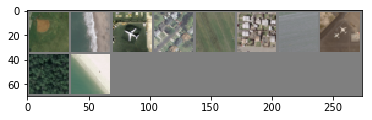

In [37]:
### PRINT IMAGES TO SCREEN TO VISUALIZE ####################################

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images)
print(labels)

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [38]:
### NETWORK ARCHITECTURE #############################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 16 * 5 * 5)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = F.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        return x

net = Net()

In [39]:
# print functions used in the network
net

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

In [40]:
### TRAIN NETWORK ######################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### CAS: increased the number of epochs to 50 to get better result
for epoch in range(50):  # loop over the dataset multiple times 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.006
[1,    10] loss: 0.006
[1,    15] loss: 0.006
[1,    20] loss: 0.006
[1,    25] loss: 0.006
[1,    30] loss: 0.006
[1,    35] loss: 0.006
[1,    40] loss: 0.006
[1,    45] loss: 0.006
[1,    50] loss: 0.006
[1,    55] loss: 0.006
[1,    60] loss: 0.006
[1,    65] loss: 0.006
[1,    70] loss: 0.006
[2,     5] loss: 0.006
[2,    10] loss: 0.006
[2,    15] loss: 0.006
[2,    20] loss: 0.006
[2,    25] loss: 0.006
[2,    30] loss: 0.006
[2,    35] loss: 0.006
[2,    40] loss: 0.006
[2,    45] loss: 0.006
[2,    50] loss: 0.006
[2,    55] loss: 0.006
[2,    60] loss: 0.006
[2,    65] loss: 0.006
[2,    70] loss: 0.006
[3,     5] loss: 0.006
[3,    10] loss: 0.006
[3,    15] loss: 0.006
[3,    20] loss: 0.006
[3,    25] loss: 0.006
[3,    30] loss: 0.006
[3,    35] loss: 0.006
[3,    40] loss: 0.006
[3,    45] loss: 0.006
[3,    50] loss: 0.006
[3,    55] loss: 0.006
[3,    60] loss: 0.006
[3,    65] loss: 0.006
[3,    70] loss: 0.006
[4,     5] loss: 0.006
[4,    10] 

[25,    65] loss: 0.004
[25,    70] loss: 0.004
[26,     5] loss: 0.004
[26,    10] loss: 0.004
[26,    15] loss: 0.003
[26,    20] loss: 0.004
[26,    25] loss: 0.003
[26,    30] loss: 0.003
[26,    35] loss: 0.003
[26,    40] loss: 0.003
[26,    45] loss: 0.004
[26,    50] loss: 0.004
[26,    55] loss: 0.003
[26,    60] loss: 0.004
[26,    65] loss: 0.003
[26,    70] loss: 0.003
[27,     5] loss: 0.003
[27,    10] loss: 0.003
[27,    15] loss: 0.004
[27,    20] loss: 0.003
[27,    25] loss: 0.004
[27,    30] loss: 0.004
[27,    35] loss: 0.003
[27,    40] loss: 0.003
[27,    45] loss: 0.003
[27,    50] loss: 0.003
[27,    55] loss: 0.003
[27,    60] loss: 0.003
[27,    65] loss: 0.004
[27,    70] loss: 0.003
[28,     5] loss: 0.003
[28,    10] loss: 0.003
[28,    15] loss: 0.003
[28,    20] loss: 0.003
[28,    25] loss: 0.003
[28,    30] loss: 0.003
[28,    35] loss: 0.003
[28,    40] loss: 0.003
[28,    45] loss: 0.003
[28,    50] loss: 0.004
[28,    55] loss: 0.003
[28,    60] loss

[50,    25] loss: 0.001
[50,    30] loss: 0.001
[50,    35] loss: 0.001
[50,    40] loss: 0.001
[50,    45] loss: 0.001
[50,    50] loss: 0.001
[50,    55] loss: 0.001
[50,    60] loss: 0.001
[50,    65] loss: 0.001
[50,    70] loss: 0.001
Finished Training


GroundTruth:  mediumresidential forest forest beach freeway airplane baseballdiamond forest agricultural forest
Predicted:  mediumresidential forest forest beach buildings airplane baseballdiamond forest agricultural forest


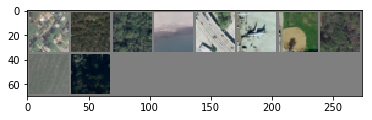

In [42]:
### CHECK ON TEST DATA ###############################################

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
### CAC needed to alphabetize classes, now the images and labels are matched
imshow(tv.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10))) ### CAS: change to 10 here

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

In [26]:
m = nn.Softmax()
print(Variable(outputs.data[0,]))
print(m(Variable(outputs.data[0,])))

Variable containing:
-8.2013
-1.1429
 9.2718
-1.0056
 1.4361
 2.3481
 5.7433
 5.3033
-8.1273
-7.5139
[torch.FloatTensor of size 10]

Variable containing:
 2.4572e-08
 2.8567e-05
 9.5266e-01
 3.2773e-05
 3.7662e-04
 9.3756e-04
 2.7959e-02
 1.8007e-02
 2.6460e-08
 4.8862e-08
[torch.FloatTensor of size 10]



C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
labels


 6
 0
 6
 6
 2
 1
 0
 6
 3
 0
[torch.LongTensor of size 10]

In [43]:
#checking accuracy
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %
